# Demo 2: Convolutional Neural Network (CNN)
This demo we will demo code for using CNN to solve the classification problem:
-   Problem: Surface defect classification (Binary classification)
-   Dataset: DCV81 A_surface dataset
    -   Train folder:
        -   A1 folder: Defect surface (17 images) 
        -   Good folder: Good surface (30 images)
    -   Val folder:
        -   A1 folder: Defect surface (6 images) 
        -   Good folder: Good surface (10 images)
    -   Test folder:
        -   A1 folder: Defect surface (6 images) 
        -   Good folder: Good surface (10 images)
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in tensorflow library can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Divide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a convolutional neural network for classification problem
-   Training model on our trainset and applying the early stopping during the training
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the label (which class) for each input image in the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,...
## 3. Task 3: Training model with data augmentation, save the best model, loading the trained model.
-   Training model train data_augmentation
-   Loading the trained model and evaluating on the test set.
*****************************************************************************

## Import all packages

In [20]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import metrics

## 0. Task 0: Preparing Dataset

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [21]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Good":0,"A1":1}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root,file)

            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(file_path)
                folder_name = os.path.basename(os.path.dirname(file_path))
                list_labels.append(label_to_number[folder_name])
    return (list_img_paths,list_labels)

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [22]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 32,
             height:int = 32) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img).convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [23]:
# Setting for image shape
width = 32*2
height = 32*2
n_channels = 1

In [24]:
# Get the list images path and list labels of train, val, test
data_dir = "/Users/user/Victor2023/Dataset/Data_CNN"
train_dir = os.path.join(data_dir,"Train")
val_dir = os.path.join(data_dir,"Val")
test_dir = os.path.join(data_dir,"Test")


list_imgs_train,list_labels_train = get_all_img_label_path(input_dir=train_dir,
                                                    img_suffix='.bmp')
list_imgs_val,list_labels_val = get_all_img_label_path(input_dir=val_dir,
                                                    img_suffix='.bmp')
list_imgs_test,list_labels_test = get_all_img_label_path(input_dir=test_dir,
                                                    img_suffix='.bmp')

In [25]:
X_train,label_train = get_data(list_img_paths=list_imgs_train,
               list_labels=list_labels_train,
               is_resize=True,
               width=width,
               height= height)

X_val,label_val = get_data(list_img_paths=list_imgs_val,
               list_labels=list_labels_val,
               is_resize=True,
               width=width,
               height= height)

X_test,label_test = get_data(list_img_paths=list_imgs_test,
               list_labels=list_labels_test,
               is_resize=True,
               width=width,
               height= height)

In [26]:
print(X_train.shape)

(47, 64, 64)


### 0.4. Standardlize dataset and reshape dataset to standard form

#### Note!
The shape of data image input for CNN model should be (N_samples,height, width, n_channels). In which:
-   N_samples: The total number of samples we have (number of images)
-   height: the height of image
-   width: the width of image
-   n_channels: number of channels in image (our case is gray scale image => n_channels = 1)

Back to our data:
-   Data is image in grayscale we resize to same size (height,width), here is 64 x 64 pixels. The number of channels in image is 1 
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height,width,n_channels)

In [27]:
n_samples_train = X_train.shape[0]
X_train = X_train.reshape((n_samples_train,height,width,n_channels))
# Scaling feature from range [0,255] to range [0,1]
X_train = X_train/255
# Convert integers to dummy variables (i.e. one hot encoded)
# Formating the truth label in form of output of model
# y now is the truth output which model must learn to predict
y_train = to_categorical(label_train)

In [28]:
n_samples_val = X_val.shape[0]
X_val = X_val.reshape((n_samples_val,height,width,n_channels))
X_val = X_val/255
y_val = to_categorical(label_val)

In [29]:
n_samples_test = X_test.shape[0]
X_test = X_test.reshape((n_samples_test,height,width,n_channels))
X_test = X_test/255
y_test = to_categorical(label_test)

In [30]:
print("The currently shape of input dataset X is:", X_train.shape)
print("The currently shape of dummy y is:", y_train.shape)

The currently shape of input dataset X is: (47, 64, 64, 1)
The currently shape of dummy y is: (47, 2)


In [31]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the train subset:", len(y_val))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 47
Number of samples in the train subset: 16
Number of samples in the test subset: 16


## 1. Task 1: Constructing model by using TensorFlow library:

### 1.1. Creating Convolutional Neural Network model
CNN with 2 Convolution Layers and 2 Fully Connected Layers.

The model CNN takes an input tensors of shape (height,width,n_channels). Here, we configure the CNN to process inputs of shape (32,32,1). So, we passing the argument input_shape = (32,32,1) to the first layer.

-   The 1st layer is Conv2D layer for the convolution operation. Here we choose feature map kernel size = (5,5)
-   The 2nd layer is the MaxPooling2D for reduces the dimensionality of each feature. Here we choose the pooling window size = (2,2)
-   The 3rd layer is Dropout for reduces the overfitting. Here we use 0.2 dropout will randomly disable 20% of the neurons.
-   The 4th, 5th, 6th layers are just the repeat of 1st,2nd,3rd layers
-   The next step is for Fully-Connected layers:
    -   Flattening the 3D outputs of previous layer to 1D by Flatten layer
    -   Adding Dense layer (Linear mapping)
-   In the last Dense layer, we use softmax as activation. It enables our to calculate the output based on the probabilities. Each class is assigned a probability. For final predict we apply the argmax to find the class with the maximum probability.

In [47]:
# define the input_shape
input_shape = (height,width,n_channels)
# Define the model CNN
model_cnn = Sequential()
## Convolution layer1 : Conv2d => MaxPool2D => Dropout
model_cnn.add(Conv2D(32,
                    kernel_size=(5,5),
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))
## Convolution layer2 : Conv2d => MaxPool2D => Dropout
model_cnn.add(Conv2D(16,
                    kernel_size=(3,3),
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))
## Fully-Connected layers:
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dense(2,activation='softmax'))

In [33]:
# Showo the model summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 16)        0         
                                                        

Model summary: 

Layer convolutional 1: 
-   input shape: (64,64,1)
    -   n_channels: 1 
-   output shape: (60,60,32) => 
    -   32 filters (32 kernals) each of size 5x5,
    -   32 biases 
-   The total parameters is: $32*5*5*1 + 32 = 832$

Layer convolutional 2: 
-   input shape: (30,30,32)
    -   n_channels: 32
-   output shape: (28,28,16)
    -   16 filters (16 kernals) each of size 3x3,
    -   16 biases 
-   The total parameters is: $16*3*3*32 + 16 = 4624$

Layer Dense 1: 
-   input shape: 14*14*16 = 3136
-   output shape: 128 => bias shape: 128
-   weight shape: (3136,128)
-   The total parameters is: $3136*128+128 = 401536$

Layer Dense 2 (final output layer): 
-   input shape: 128
-   output shape: 2 => bias shape: 2
-   weight shape: (128,2)
-   The total parameters is: $128*2 + 2 = 258$

### 1.2. Training model with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau

In [34]:
# Define EarlyStopping, ModelCheckpoint, ReduceLearningRateOnPlateau.
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)
mc = ModelCheckpoint('best_model_cnn_DCV81.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30,
                              min_lr=0.0001,
                              mode = 'min')

In [35]:
# Training model with 500 epochs with earlystopping
epochs = 500
optimizer = keras.optimizers.Adam()
loss = keras.losses.categorical_crossentropy
q_metrics = ['accuracy']
model_cnn.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = model_cnn.fit(X_train,y_train,
                         batch_size=32,
                         epochs = epochs,
                         validation_data=(X_val,y_val),
                         verbose=2,
                         callbacks=[es,mc,reduce_lr])

Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model_cnn_DCV81.h5
2/2 - 1s - loss: 0.6966 - accuracy: 0.5532 - val_loss: 0.6581 - val_accuracy: 0.6250 - lr: 0.0010 - 1s/epoch - 697ms/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6973 - accuracy: 0.6383 - val_loss: 0.6677 - val_accuracy: 0.6250 - lr: 0.0010 - 203ms/epoch - 101ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6577 - accuracy: 0.6383 - val_loss: 0.6635 - val_accuracy: 0.6250 - lr: 0.0010 - 202ms/epoch - 101ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6532 - accuracy: 0.6383 - val_loss: 0.6590 - val_accuracy: 0.6250 - lr: 0.0010 - 231ms/epoch - 115ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6517 - accuracy: 0.6383 - val_loss: 0.6587 - val_accuracy: 0.6250 - lr: 0.0010 - 193ms/epoch - 96ms/step
Epoch 6/500

Epoc

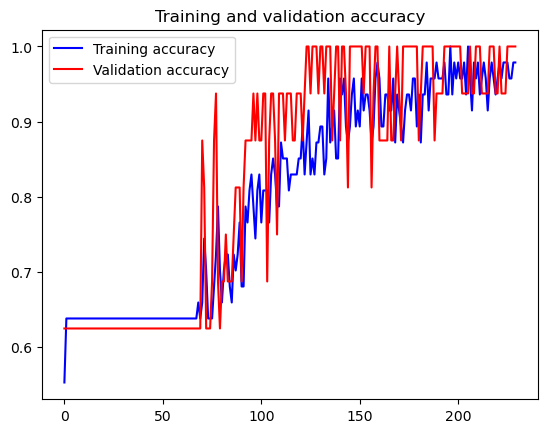

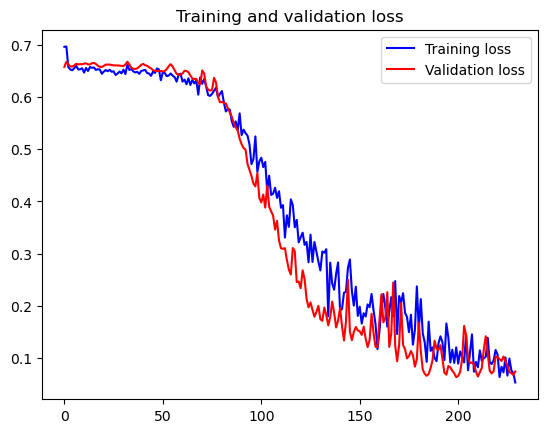

In [36]:
# Plot the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 2. Task 2: Evaluating the performance of trained model on the testset

### 2.1. Predict the label (which class) for each input image in the testset

In [37]:
output_test = model_cnn.predict(X_test)

1/1 [==============================] - 0s 139ms/step


In [38]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

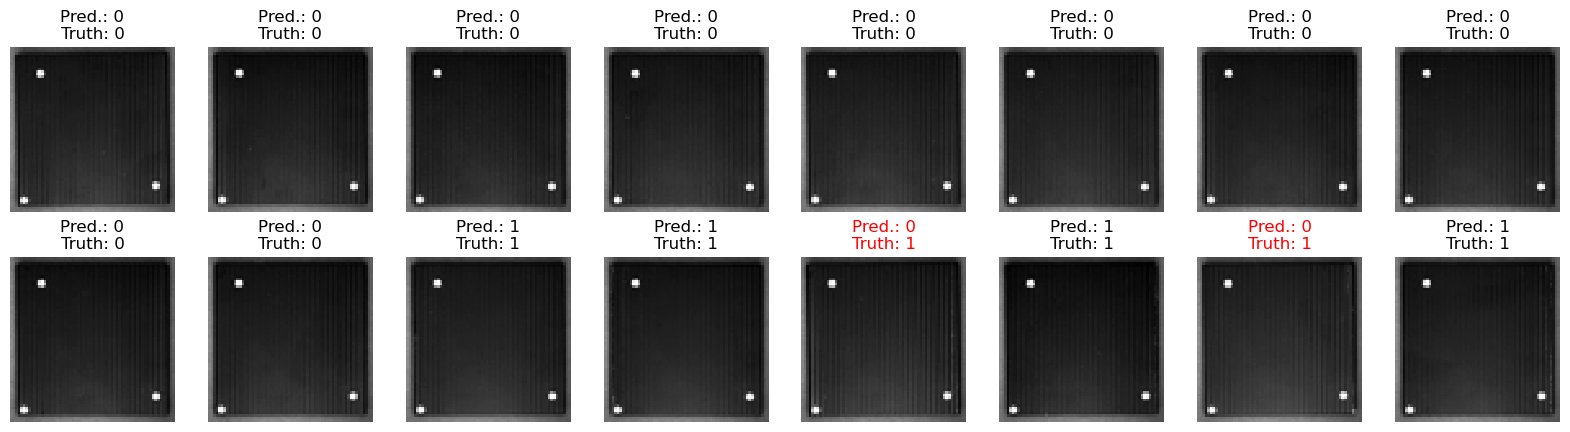

In [41]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,5))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

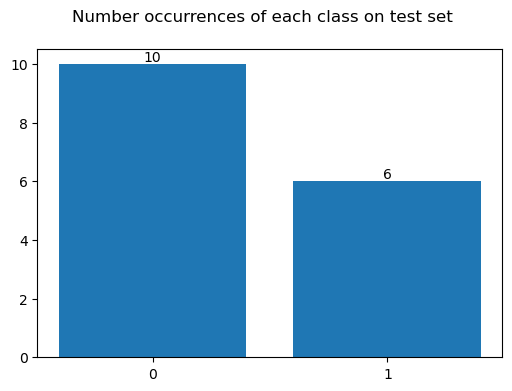

In [42]:
nb_classes = len(np.unique(truth_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(truth_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [43]:
# Classification report:
print(f"Classification report for classifier {model_cnn}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1382afa60>:
              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091        10
           1     1.0000    0.6667    0.8000         6

    accuracy                         0.8750        16
   macro avg     0.9167    0.8333    0.8545        16
weighted avg     0.8958    0.8750    0.8682        16




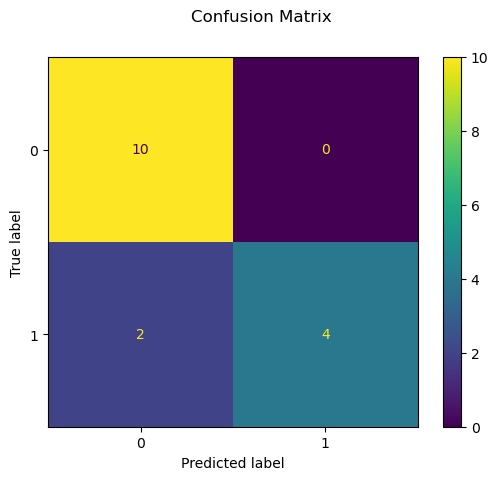

In [44]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 3. Task 3: Loading the trained model

### 3.1. Loading the trained model and getting the weight and bias of first layer
We have named the best model during the training process with data generator as "best_model_cnn_DCV81.h5"

In [53]:

trained_model_dir = "/Users/user/AI_Class/P4_DeepLearning/S2_ConvolutionalNN/best_model_cnn_DCV81.h5"
load_model = keras.models.load_model(trained_model_dir)

In [54]:
# Show the layer name of all layer in load_model:
for layer in load_model.layers:
    print(layer.name)

conv2d
activation
max_pooling2d
dropout
conv2d_1
activation_1
max_pooling2d_1
dropout_1
flatten
dense
dense_1


In [55]:
# Getting the weights and biases of the first layer in the load_model
weights, biases = load_model.layers[0].get_weights()

In [56]:
biases.shape

(32,)

In [57]:
weights.shape

(5, 5, 1, 32)

In [58]:
# layer to get the feature output under conv2d
layer_conv2d_0 = Model(inputs=load_model.inputs, outputs=load_model.layers[0].output)
# layer to get the feature output under conv2d and activation
layer_activation_1 = Model(inputs=load_model.inputs, outputs=load_model.layers[1].output)
# layer to get the feature output under conv2d and activation then pooling
layer_pooling_2 = Model(inputs=load_model.inputs, outputs=load_model.layers[2].output)

In [59]:
layer_conv2d_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


### 3.2. Plotting the convolutional map (feature map, filter or kernel)

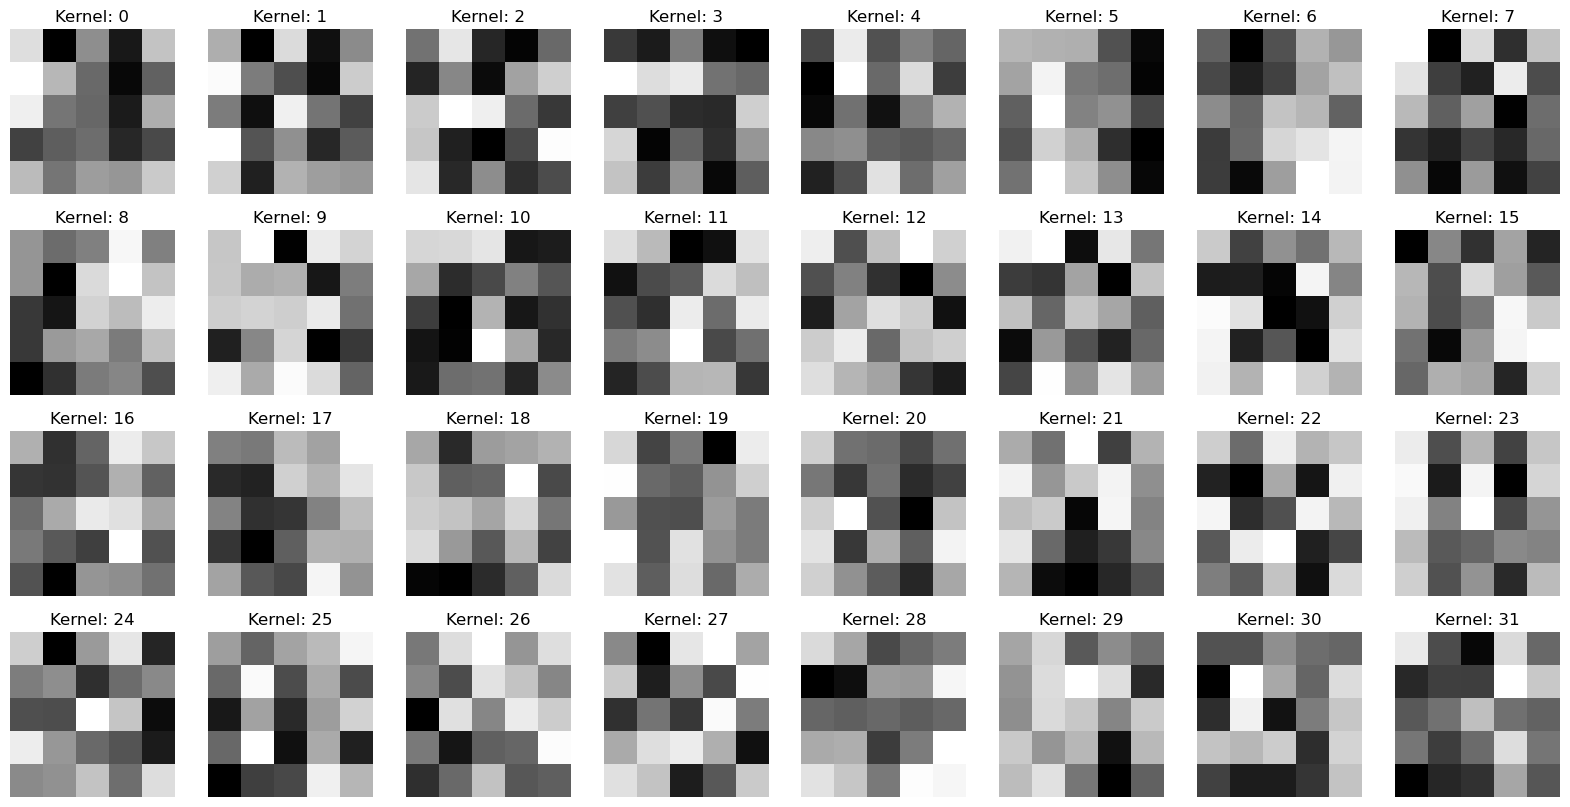

In [62]:
# Visualize the 32 convolutional maps (filters or kernels)
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(weights[:,:,0,index], cmap = plt.cm.gray_r, interpolation = "nearest")
        axes[r,c].set_title(f"Kernel: {index}")

In [63]:
# Show the value of kernel 0
weights[:,:,0,0]

array([[-0.06846844,  0.11187173, -0.00318828,  0.09191073, -0.04624948],
       [-0.09523966, -0.03687208,  0.02613985,  0.10470523,  0.03201559],
       [-0.08194679,  0.01658086,  0.02791622,  0.08938537, -0.02912568],
       [ 0.05924494,  0.03512317,  0.02288282,  0.07986484,  0.05191261],
       [-0.04014698,  0.01651057, -0.01539473, -0.0101687 , -0.0520879 ]],
      dtype=float32)

### 3.3. Plotting the feature images (results under the convolutional map)

In [65]:
# Compute the feature images of first input image in testset under conv2d, activation, pooling
feature_results0 = layer_conv2d_0.predict(X_test[:1,:,:,:])
feature_results1 = layer_activation_1.predict(X_test[:1,:,:,:])
feature_results2 = layer_pooling_2.predict(X_test[:1,:,:,:])

1/1 [==============================] - 0s 90ms/step


In [66]:
# Print the feature images shape
print(feature_results0.shape)
print(feature_results1.shape)
print(feature_results2.shape)

(1, 60, 60, 32)
(1, 60, 60, 32)
(1, 30, 30, 32)


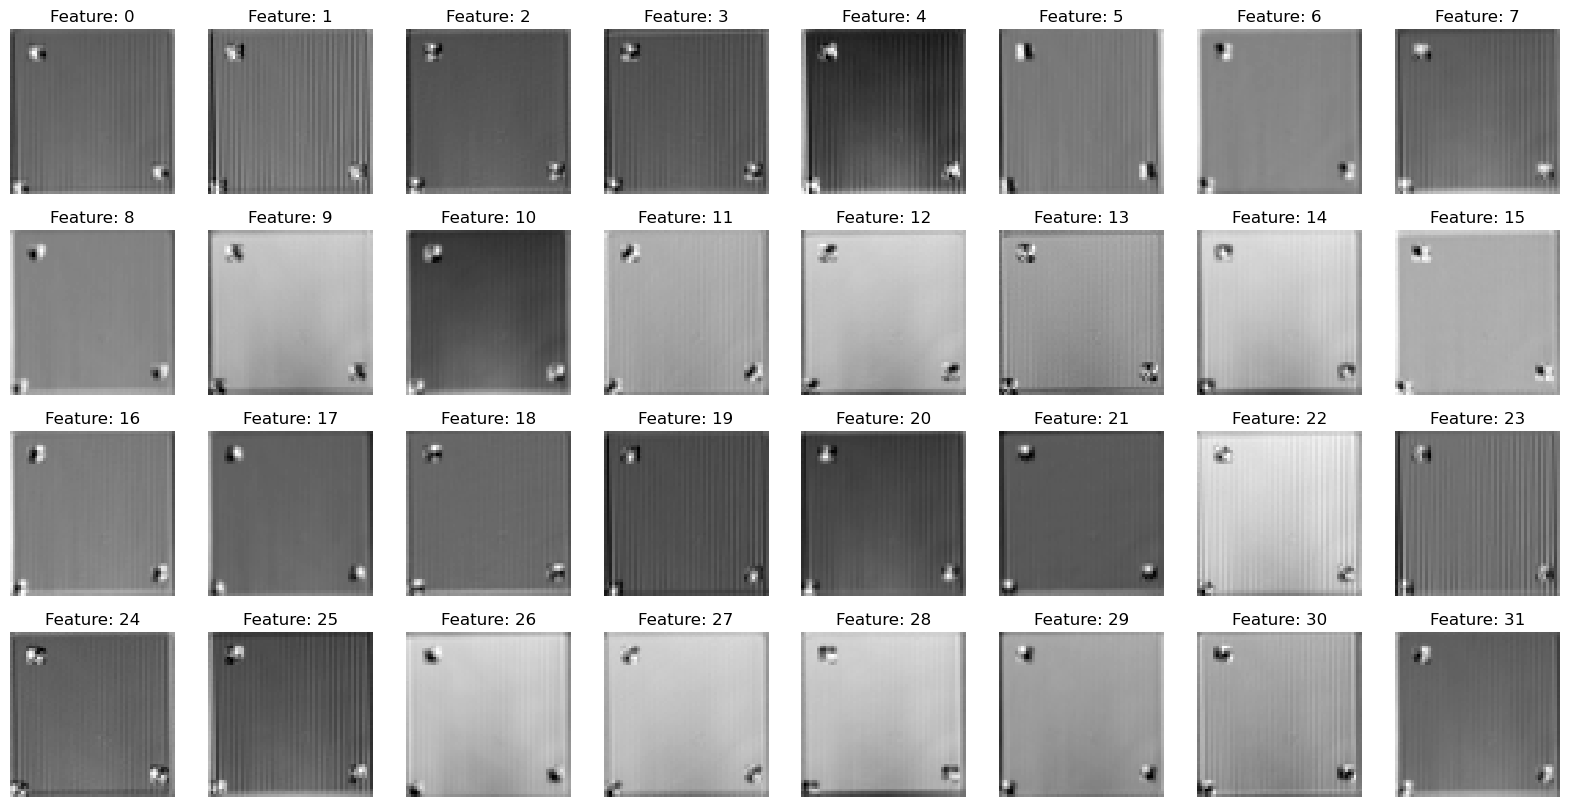

In [71]:
# Visualize the 32 features image under the conv2d
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_results0[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")

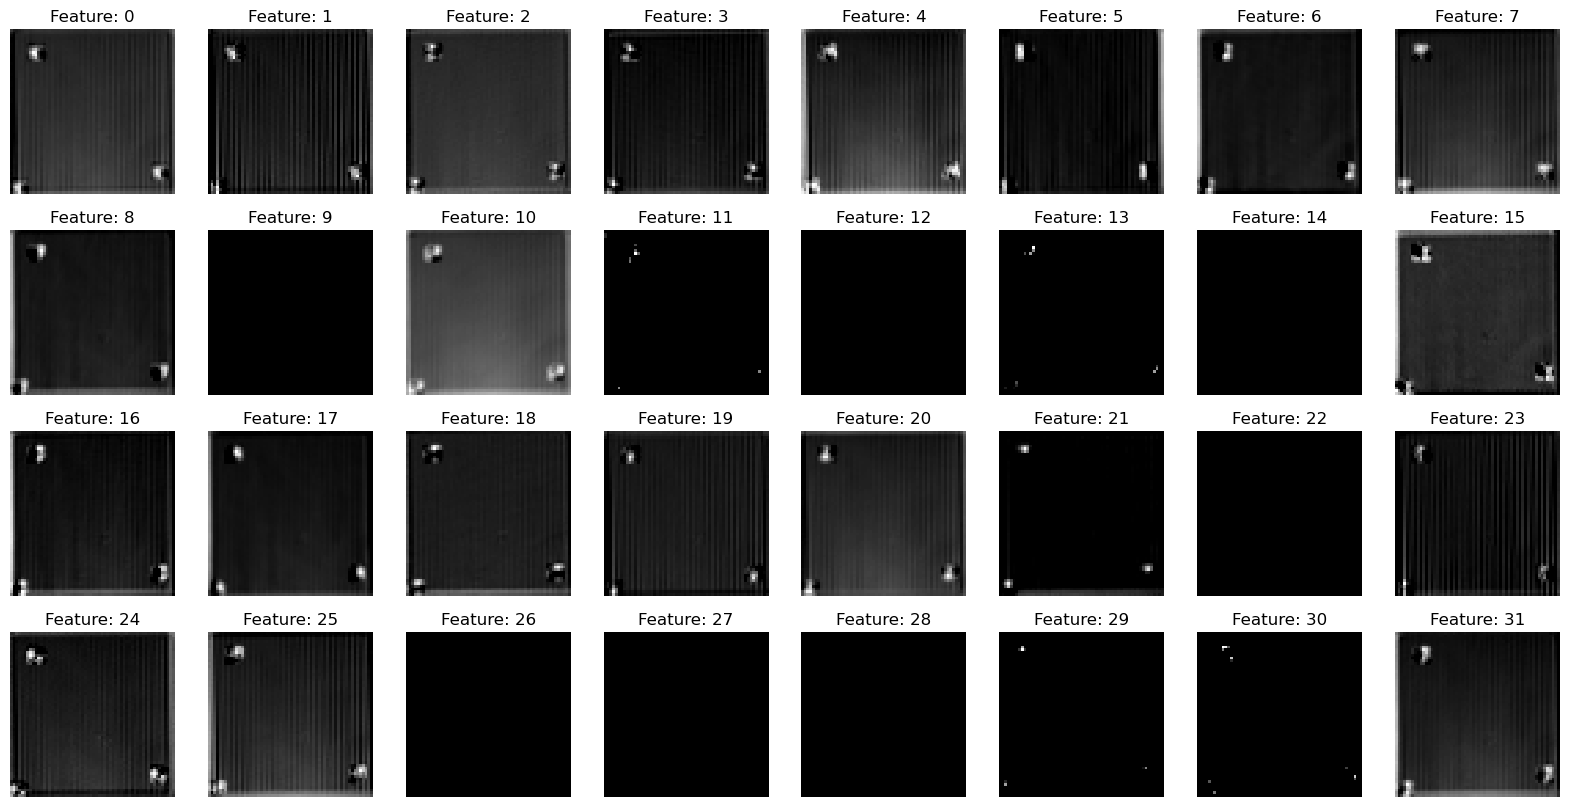

In [70]:
# Visualize the 32 features image under the conv2d and activation
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_results1[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")

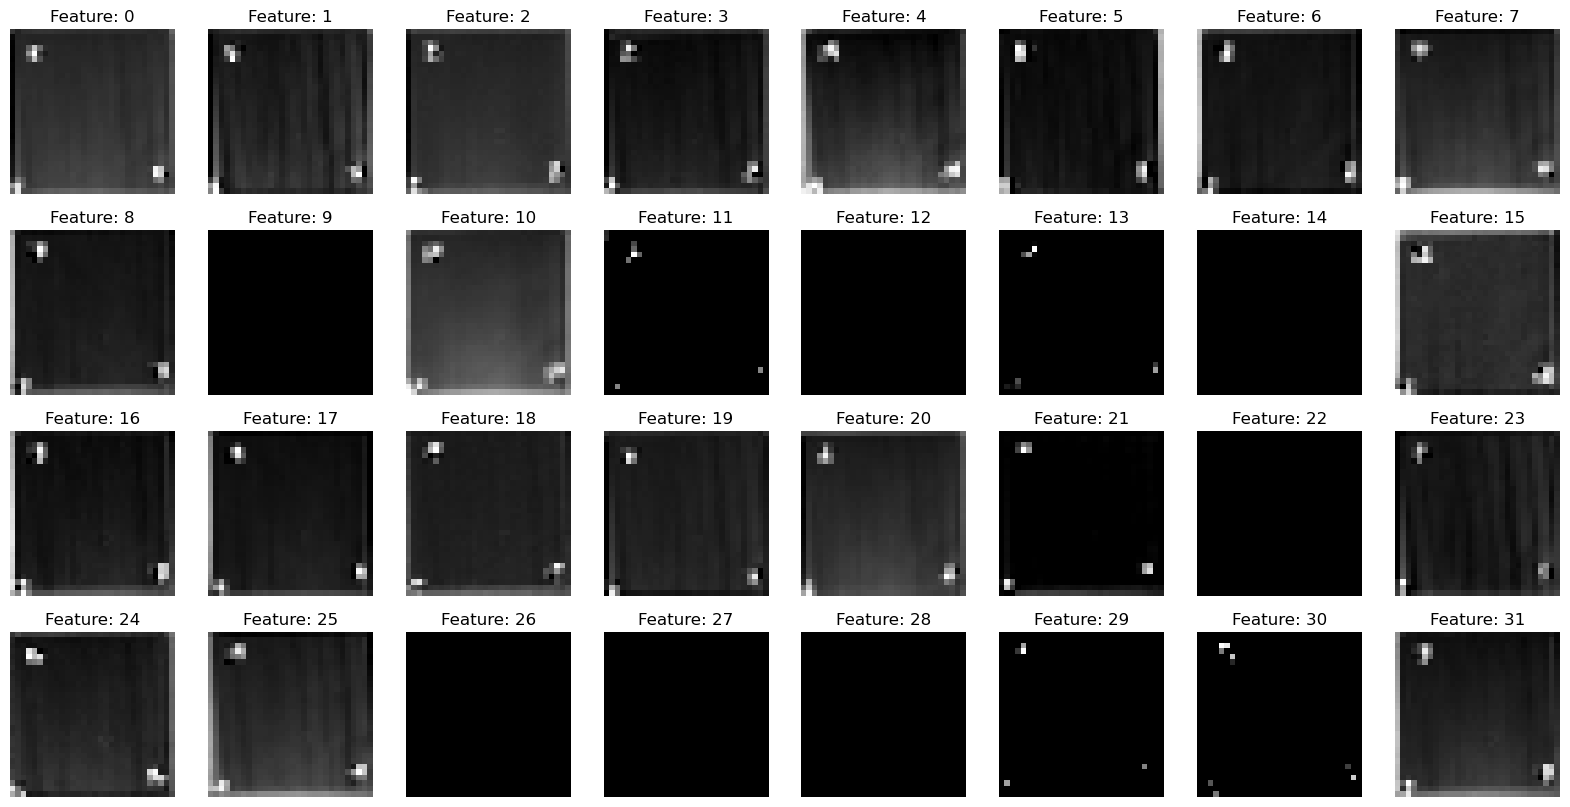

In [73]:
# Visualize the 32 features image under the conv2d
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_results2[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")

### 3.4. Apply conv2d on the original image and show the feature results

In [74]:
# Create a model with only one conv2d kernel_size = (5,5)
input_shape_test=(1856,1856,1)
model_layer0 = Sequential()
## Convolution layer1 : Conv2d
model_layer0.add(Conv2D(32,
                    kernel_size=(5,5),
                    input_shape = input_shape_test))

In [75]:
# Setting the weights for the model by the weight from loaded model in previous part	
model_layer0.set_weights(load_model.layers[0].get_weights())

In [78]:
# Prepare the original dataset without rescale
data = []
for i in range(len(list_imgs_test)):
    path_img = list_imgs_test[i]
    img = Image.open(path_img).convert('L')
    data.append(np.array(img))
X_test_original = np.array(data)

In [81]:
# Reshape X_test_original to correct form
n_test_original = X_test_original.shape[0]
X_test_original = X_test_original.reshape((n_test_original,1856,1856,n_channels))
X_test_original = X_test_original/255
print(X_test_original.shape)

(16, 1856, 1856, 1)


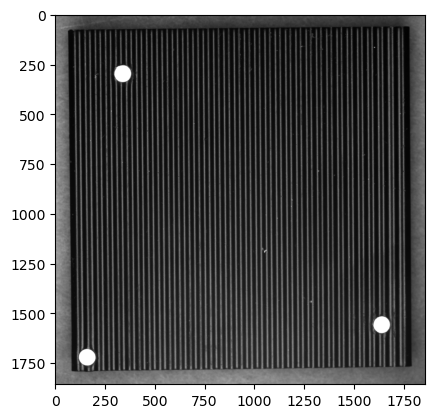

In [82]:
# Show the first image in datatest
plt.imshow(X_test_original[0,:,:,0],cmap ='gray')

In [83]:
# Getting the features under the conv2d 
feature_0 = model_layer0.predict(X_test_original[:1,:,:,:])

1/1 [==============================] - 1s 720ms/step


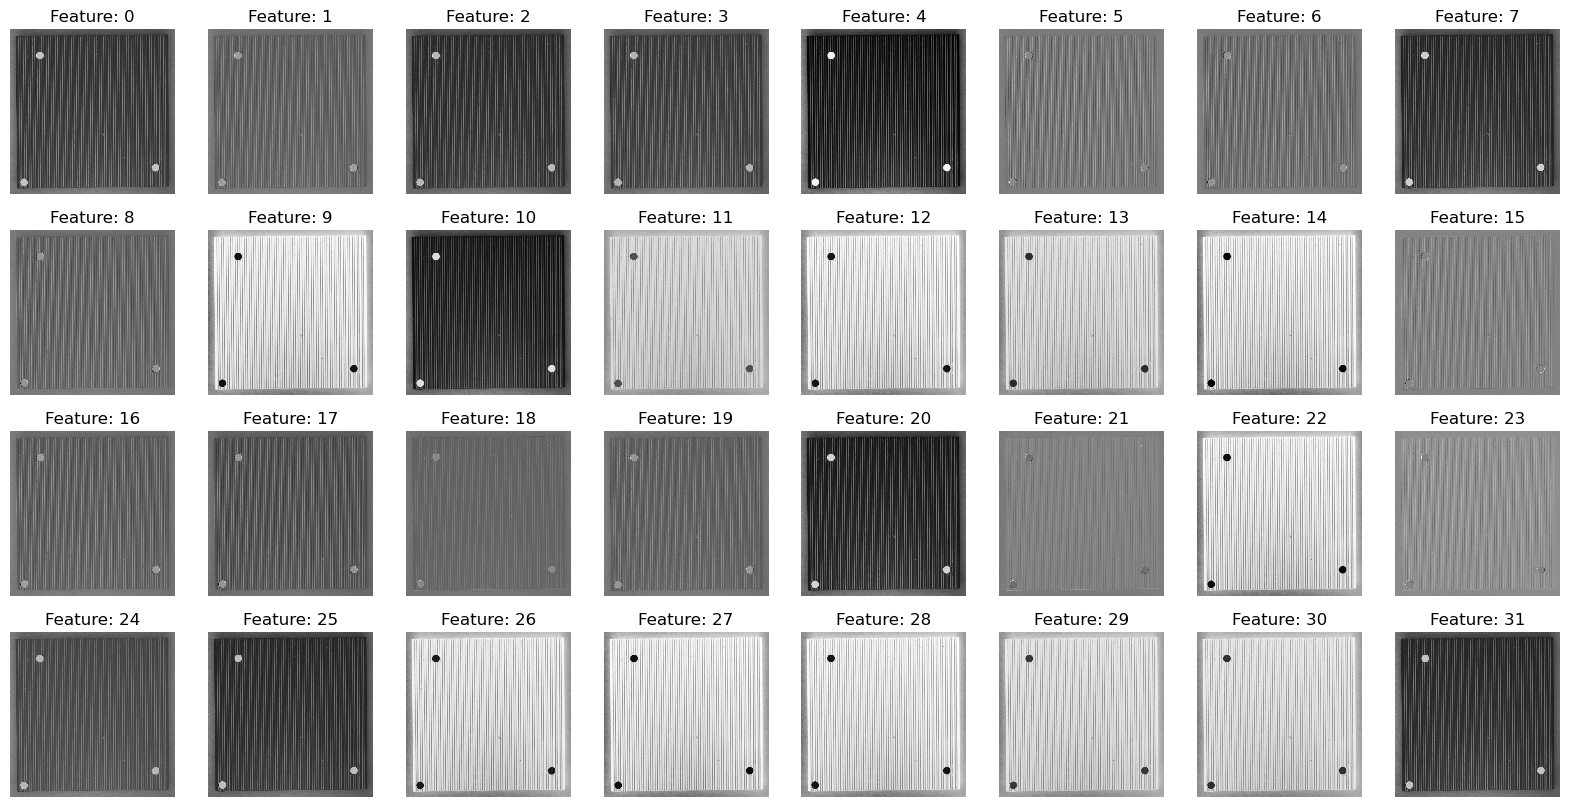

In [84]:
# Visualize the 32 features image under the conv2d
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_0[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")

In [85]:
# Apply the activation function on the features
f_Relu = Activation('relu')

In [86]:
feature_relu = f_Relu(feature_0)

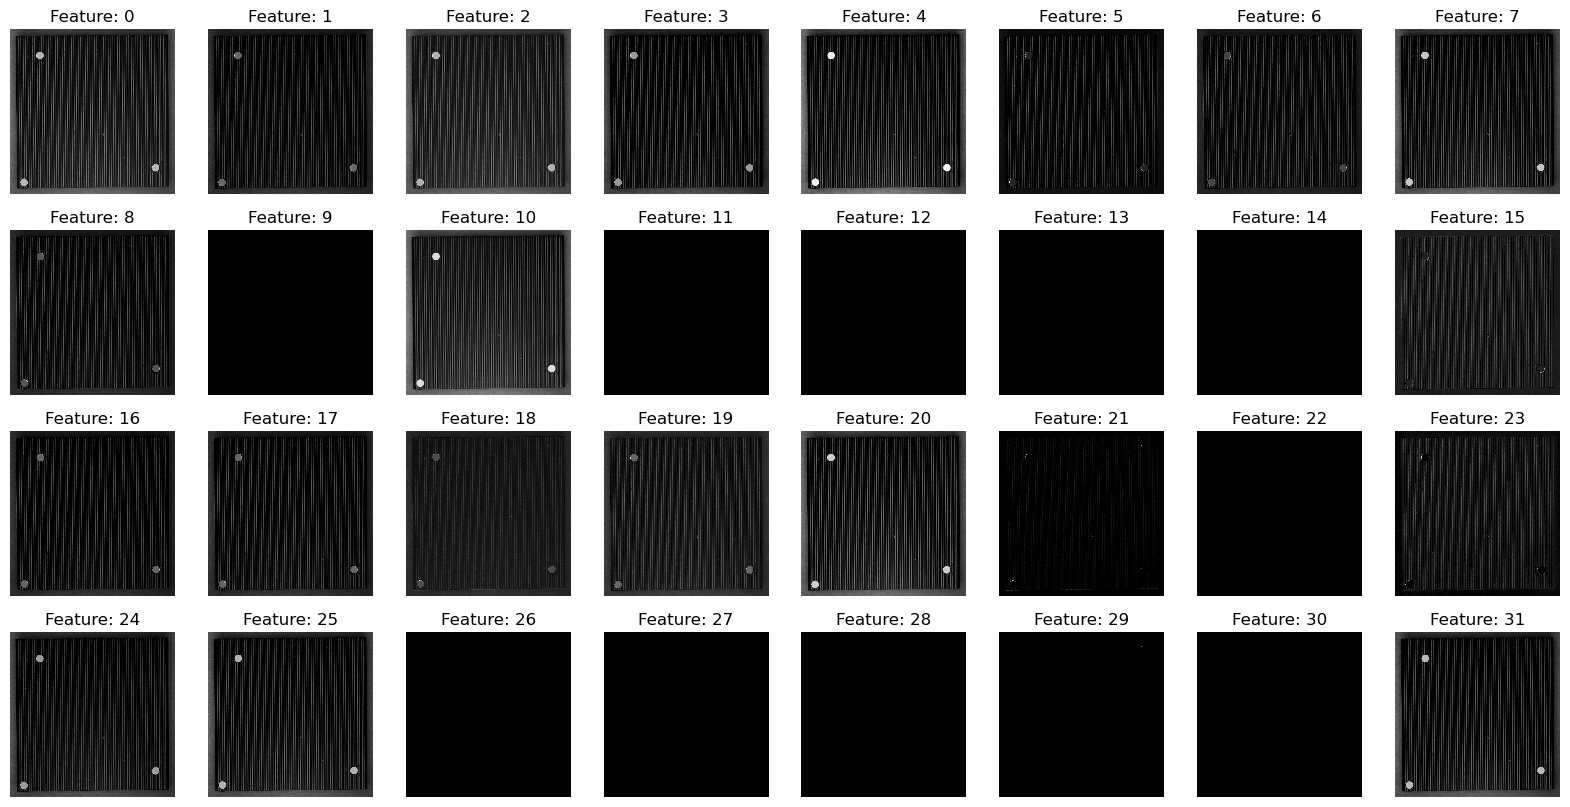

In [87]:
# Visualize the 32 features image under the conv2d and Relu
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_relu[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")

In [88]:
f_Sigmoid = Activation('sigmoid')

In [89]:
feature_sigmoid = f_Sigmoid(feature_0)

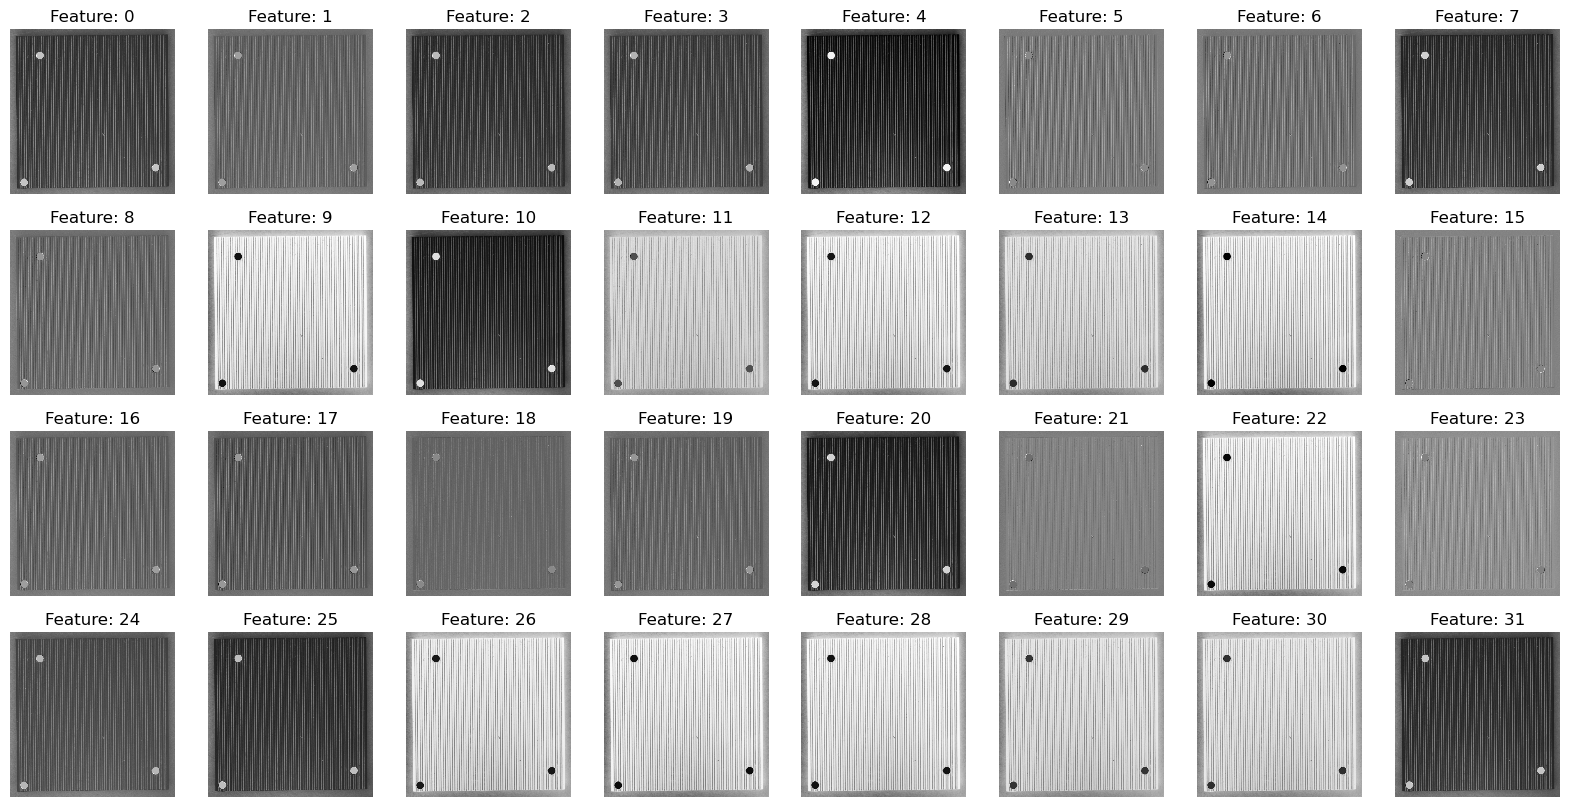

In [90]:
# Visualize the 32 features image under the conv2d and Sigmoid
_,axes = plt.subplots(nrows = 4,ncols = 8, figsize= (20,10))
for r in range(4):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        axes[r,c].imshow(feature_sigmoid[0,:,:,index], cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Feature: {index}")